In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier


In [2]:
df = pd.read_csv("../data/interim/data_pre_processados.csv")
df.head()

,limite,sexo,educacao,estado_civil,idade,status_0509,status_0508,status_0507,status_0506,status_0505,...,saldo_0506,saldo_0505,saldo_0504,pago_0509,pago_0508,pago_0507,pago_0506,pago_0505,pago_0504,mau
0,20000,feminino,universidade,casado,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,sim
1,120000,feminino,universidade,solteiro,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,sim
2,90000,feminino,universidade,solteiro,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,nao
3,50000,feminino,universidade,casado,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,nao
4,50000,masculino,universidade,casado,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,nao


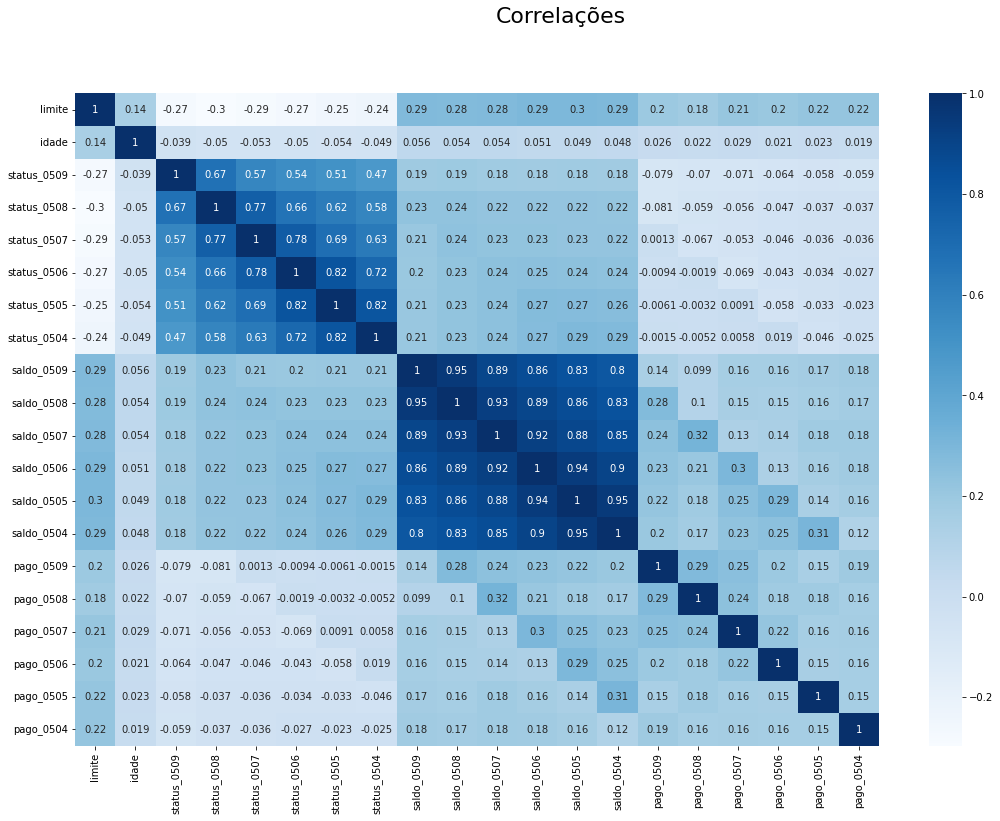

In [3]:
correl = df.corr(method='pearson')
plt.figure(figsize=(18,12))
sns.heatmap(correl, annot=True, cmap="Blues")
plt.suptitle('Correlações', fontsize=22)
plt.show()

In [4]:
sex = {"masculino": 1, "feminino":2}
education = {"pós-graduação":1, "universidade":2, "ensino médio":3, "outros":4}
marriage = {"casado":1, "solteiro":2, "outros":3}
mau = {"nao":0, "sim":1}

df["sexo"] = df["sexo"].map(sex)
df["educacao"] = df["educacao"].map(education)
df["estado_civil"] = df["estado_civil"].map(marriage)
df['mau'] = df['mau'].map(mau)
df.head()

,limite,sexo,educacao,estado_civil,idade,status_0509,status_0508,status_0507,status_0506,status_0505,...,saldo_0506,saldo_0505,saldo_0504,pago_0509,pago_0508,pago_0507,pago_0506,pago_0505,pago_0504,mau
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df_dicionario = pd.read_csv("../references/dicionario_dados.csv")
nominal_columns = df_dicionario['Col_Trad'][df_dicionario['Tipo'] == 'cat'].values
numerical_columns = df_dicionario['Col_Trad'][df_dicionario['Tipo'] == 'num'].values

In [6]:
preprocessor = ColumnTransformer([
    ("one-hot-encoding", OneHotEncoder(), nominal_columns),
    ("scaler", StandardScaler(), numerical_columns)
])

In [7]:
X = df.drop(columns=['mau'], axis=1)
y = df['mau'].ravel()

In [8]:
models = {
    'logistic-regression': LogisticRegression(solver='lbfgs', max_iter=3000),
    'KNN': KNeighborsClassifier(weights= "uniform",algorithm="brute", leaf_size=2,n_neighbors=50),
    'SVM': SVC(gamma='auto'),
    'gradient-boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0),
    'Percéptron Multi-Camadas': MLPClassifier(random_state=0, activation='relu', solver='adam', learning_rate='adaptive', max_iter=200),
    'XGBoost': XGBClassifier(n_estimators=200, verbosity=0, use_label_encoder=False, random_state=0, max_depth= 5,gamma= 2)
}

In [25]:
%%time
results = {}
n_splits = 30
for model_name, model in tqdm(models.items()):
    scores = cross_validate(
        estimator = Pipeline(steps=[
            ("preprocessamento", preprocessor),
            ("modelo", model)
        ]),
        X = X,
        y = y,
        cv = ShuffleSplit(n_splits=n_splits, test_size=.2),
        n_jobs = 4,
        scoring = ['accuracy','f1', 'precision', 'recall', 'roc_auc']
    )
    scores['model'] = [model_name] * n_splits
    if not(results):
        results = scores
    else:
        for key in results:
            results[key] = list(results[key])
            results[key].extend(scores[key])

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 682 ms, sys: 199 ms, total: 882 ms
Wall time: 3min 25s


In [26]:
resultados = pd.DataFrame(results).groupby('model').agg([np.mean, np.std]).transpose()
resultados.style.background_gradient(cmap='Blues', axis=1)

In [9]:
nominal_preprocessing = Pipeline([    
    ("missing", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder())
])
quantitative_preprocessing = Pipeline([
    ("missing", SimpleImputer()),
    ("scaler", StandardScaler())
])
preprocessing = ColumnTransformer([
    ("nominal", nominal_preprocessing, nominal_columns),
    ("quantitative", quantitative_preprocessing, numerical_columns)
])

In [10]:
models = {
    'knn': KNeighborsClassifier(),
    'logistic regression': LogisticRegression(max_iter=3000)
}
params = {
    'knn': {
        'n_neighbors': [3, 5, 15],
    },
    'logistic regression': {
        'C': [1, 10, 100]
        
    }
}

In [17]:
results = {}
n_splits = 5
for model_name, model in tqdm(models.items()):
    
    param_grid = {
        'preprocessing__quantitative__missing__strategy': ['mean', 'median'],
        **{f"model__{key}": value for key, value in params[model_name].items()}
    }
    approach = Pipeline([
        ('preprocessing', preprocessing),
        ('model', model)
    ])
    gs = GridSearchCV(
        estimator=approach,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5
    )
    scores = cross_validate(
        estimator = gs,
        X=X,
        y=y,
        cv = ShuffleSplit(n_splits=n_splits, test_size=.2),
        n_jobs = 4,
        verbose = 10,
        scoring = ['accuracy', 'precision', 'recall','f1', 'roc_auc']
    )
    scores['model'] = [model_name] * n_splits
    if not(results):
        results = scores
    else:
        for key in results:
            results[key] = list(results[key])
            results[key].extend(scores[key])

  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:  2.9min remaining:  1.9min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   15.8s remaining:   23.6s
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:   15.9s remaining:   10.6s


CPU times: user 166 ms, sys: 67.2 ms, total: 234 ms
Wall time: 4min 36s


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   19.9s finished


In [19]:
resultados = pd.DataFrame(results).groupby('model').agg([np.mean, np.std]).transpose()
resultados.style.background_gradient(cmap='Blues', axis=1)